In [1]:
#Loading in our data
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards_5.json.gz --no-check-certificate
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards.csv --no-check-certificate
!gzip -d Gift_Cards_5.json.gz
!head Gift_Cards_5.json
!head Gift_Cards.csv
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Gift_Cards.json.gz --no-check-certificate
!gzip -d meta_Gift_Cards.json.gz
!head meta_Gift_Cards.json

/bin/bash: /home/aiden/miniconda3/envs/homeworkenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-11-06 16:19:26--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 176952 (173K) [application/x-gzip]
Saving to: ‘Gift_Cards_5.json.gz’

Gift_Cards_5.json.g 100%[===================>] 172.80K  --.-KB/s    in 0.08s   

2023-11-06 16:19:26 (2.00 MB/s) - ‘Gift_Cards_5.json.gz’ saved [176952/176952]

/bin/bash: /home/aiden/miniconda3/envs/homeworkenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-11-06 16:19:26--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Gift_Cards.csv
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 

In [2]:
#Installing packages that do not come pre installed
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install umap-learn

/bin/bash: /home/aiden/miniconda3/envs/homeworkenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.3 MB/s eta 0:00:001.0 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [71 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-311
      creating build/lib.linux-x86_64-cpython-311/torch_scatter
      copying torch_scatter/scatter.py -> build/lib.linux-x86_64-cpython-311/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.linux-x86_64-cpython-311/torch_scatter
      copying torch_scatter/segment_csr.py -> build/lib.linux-x86_64-cpython-311/torch_scatter
      copying torch_scatter/placeholder

In [2]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.0.1+cu117; Torch-cuda version: 11.7; Torch Geometric version: 2.4.0.


In [4]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [31]:
##Defining classes

class Product:
  def __init__(self, title, asin, description, also_bought, categories):
    self.title = title #name, string
    self.asin = asin #string
    self.description = description #string
    # self.features = features # String[]
    self.also_bought = also_bought #asin[]
    self.categories = set(categories) #categories[]


  def __str__(self):
    return f"Product {self.title}"

class Category:
  def __init__(self, name):
    self.name = name
    self.products = []

  def add_to_category(self, product):
    self.products.append(product)

  def __str__(self):
    return f"Category {self.name} has {len(self.products)} in it."

class User:
  def __init__(self, reviewerID):
    self.reviewerID = reviewerID
    self.products_reviewed = []
    #maybe we can add the categories that they reviewed?

  def add_to_reviewed(self, product):
    self.products_reviewed.append(product)

  def __str__(self):
    return f"User {self.reviewerID} has reviewed {len(self.products_reviewed)} products"

In [32]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = 'Gift_Cards_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "meta_Gift_Cards.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [33]:
products = {}
all_categories = {}
users = {}

def process_review_data(review):
  try:
    userID = review['reviewerID']
  except:
    print(review)
  if userID not in users:
    new_user = User(userID)
    users[userID] = new_user
  users[userID].add_to_reviewed(review['asin'])

def process_metadata(metadata):
  asin = metadata['asin']
  # features = metadata['features']
  also_bought = metadata['also_buy']
  description = metadata['description']
  categories = metadata['category']
  title = metadata['title']
  if asin not in products:
    new_product = Product(title, asin, description, also_bought, categories)
    products[asin] = new_product
  for category in categories:
    if category not in all_categories:
      all_categories[category] = Category(category)
    all_categories[category].add_to_category(asin)


def load_data():
  for line in review_data:
    process_review_data(line)
  for line in file_metadata:
    process_metadata(line)


In [34]:
load_data()

In [35]:
import torch
from torch_geometric.data import Data

# Create instances of your classes
# This is just a placeholder. Replace this with your actual data.
# products = [...]
# categories = [...]
# users = [...]

# Create mappings from unique IDs to consecutive integers
unique_user_id = [user for user in users]
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = [product for product in products]
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

unique_category_id = [category for category in all_categories]
unique_category_id = pd.DataFrame(data={
   'categoryId': unique_category_id,
   'mappedID': pd.RangeIndex(len(unique_category_id)),
})
# print(unique_user_id)
# Construct the edge indices
# User to Product (Review)
user_product_edges = []
for user_name in users:
   user_object = users[user_name]
   for product_id in users[user_name].products_reviewed:
       product = products[product_id]
       user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == user_object.reviewerID, 'mappedID'].values[0],
                                unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]])
user_product_edges = torch.tensor(user_product_edges, dtype=torch.long)

# Product to Product (Also Bought)
product_product_edges = []
for product_id in products:
   product = products[product_id]
   for also_bought_product in products[product_id].also_bought:
      #  print(also_bought_product)
 
       if (unique_product_id['productId'] == also_bought_product).any():  
         product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0],
                                   unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
# print(len(product_product_edges))
product_product_edges = torch.tensor(product_product_edges, dtype=torch.long)

# Product to Category
product_category_edges = []
for product_id in products:
   product = products[product_id]
   for category in products[product_id].categories:
       product_category_edges.append([unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0],
                                    unique_category_id.loc[unique_category_id['categoryId'] == category, 'mappedID'].values[0]])

product_category_edges = torch.tensor(product_category_edges, dtype=torch.long)

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]


In [36]:
print(len(product_product_edges), len(product_category_edges), len(product_category_edges))

5993 3622 3622


In [42]:
def convert_description_to_embedding(description):
    return torch.rand(1,128)

#sentence transformer

In [43]:
# Create product features
product_features = torch.zeros((len(unique_product_id), 128))
for product_id in products:
   product = products[product_id]
   mapped_id = unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]
   product_features[mapped_id] = convert_description_to_embedding(product.description)

In [44]:
# user_features = torch.zeros((len(unique_user_id), 1))
# for user_id in users:
#    user = users[user_id]
#    mapped_id = unique_user_id.loc[unique_user_id['userId'] == user.reviewerID, 'mappedID'].values[0]
#    user_features[mapped_id] = user.rating

AttributeError: 'str' object has no attribute 'reviewerID'

In [46]:
from torch_geometric.data import HeteroData
from sklearn.feature_extraction.text import TfidfVectorizer

# Create node feature tensors
# product_features = torch.tensor([products[product].description for product in products], dtype=torch.float)
# user_features = torch.tensor([user.rating for user in users], dtype=torch.float)

# Create an instance of the HeteroData class
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
# data['User'].x = user_features

# Add edge indices to the HeteroData object
data['User', 'Product', 'REVIEWS'].edge_index = user_product_edges
data['Product', 'Product', 'ALSO_BOUGHT'].edge_index = product_product_edges
data['Product', 'Category', 'HAS_CATEGORY'].edge_index = product_category_edges

In [19]:
# data['Product'].x = product_features
# data['User'].x = user_features

In [47]:
data

HeteroData(
  Product={ x=[1547, 128] },
  (User, Product, REVIEWS)={ edge_index=[2972, 2] },
  (Product, Product, ALSO_BOUGHT)={ edge_index=[5993, 2] },
  (Product, Category, HAS_CATEGORY)={ edge_index=[3622, 2] }
)

In [50]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.nn import to_hetero

g = torch_geometric.utils.to_networkx(data.to_homogeneous())
# Networkx seems to create extra nodes from our heterogeneous graph, so I remove them
isolated_nodes = [node for node in g.nodes() if g.out_degree(node) == 0]
[g.remove_node(i_n) for i_n in isolated_nodes]
# Plot the graph
nx.draw(g, with_labels=True)
plt.show()

KeyError: 'User'

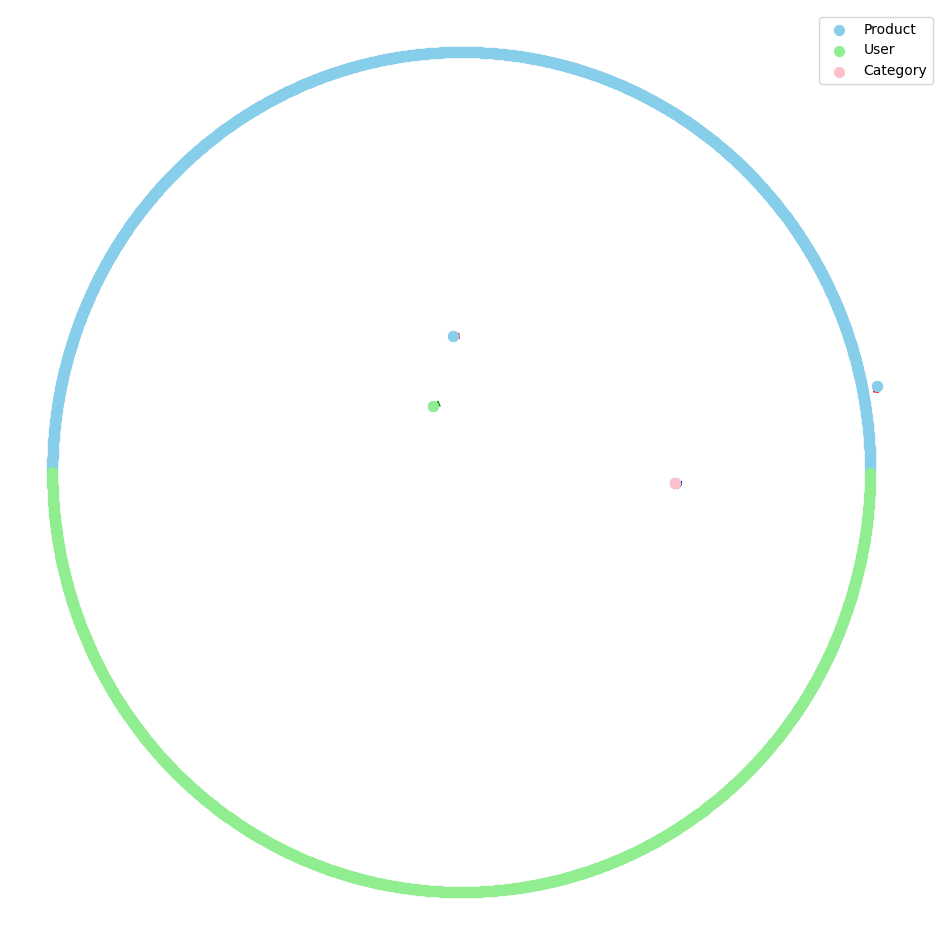

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
g = nx.DiGraph()

# Add nodes for 'Product'
for i in range(data['Product']['x'].size(0)):
    g.add_node(f'Product_{i}', type='Product', color='skyblue')

# Add nodes for 'User' and 'Category' assuming they are numbered consecutively
# and adjusting the numbers to fit your data
for i in range(data['User', 'Product', 'REVIEWS']['edge_index'].max().item() + 1):
    g.add_node(f'User_{i}', type='User', color='lightgreen')

for i in range(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][1].max().item() + 1):
    g.add_node(f'Category_{i}', type='Category', color='pink')

# Add edges for 'REVIEWS'
for i in range(data['User', 'Product', 'REVIEWS']['edge_index'].shape[1]):
    source = int(data['User', 'Product', 'REVIEWS']['edge_index'][0, i])
    target = int(data['User', 'Product', 'REVIEWS']['edge_index'][1, i])
    g.add_edge(f'User_{source}', f'Product_{target}', type='REVIEWS', color='green')

# Add edges for 'ALSO_BOUGHT'
for i in range(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'].shape[1]):
    source = int(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'][0, i])
    target = int(data['Product', 'Product', 'ALSO_BOUGHT']['edge_index'][1, i])
    g.add_edge(f'Product_{source}', f'Product_{target}', type='ALSO_BOUGHT', color='red')

# Add edges for 'HAS_CATEGORY'
for i in range(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'].shape[1]):
    source = int(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][0, i])
    target = int(data['Product', 'Category', 'HAS_CATEGORY']['edge_index'][1, i])
    g.add_edge(f'Product_{source}', f'Category_{target}', type='HAS_CATEGORY', color='blue')


plt.figure(figsize=(12, 12))  # Increase the figure size

# Now we draw the graph
pos = nx.kamada_kawai_layout(g)  # This layout might give you a better spatial separation

# Draw nodes by type with specified colors
for node_type, color in [('Product', 'skyblue'), ('User', 'lightgreen'), ('Category', 'pink')]:
    nx.draw_networkx_nodes(
        g, 
        pos, 
        nodelist=[n for n, attr in g.nodes(data=True) if attr['type'] == node_type],
        node_color=color,
        label=node_type,
        node_size=50  # Adjust node size
    )

# Draw edges by type with specified colors and reduce the width to minimize clutter
for edge_type, color in [('REVIEWS', 'green'), ('ALSO_BOUGHT', 'red'), ('HAS_CATEGORY', 'blue')]:
    edges = [(u, v) for u, v, e in g.edges(data=True) if e['type'] == edge_type]
    nx.draw_networkx_edges(g, pos, edgelist=edges, edge_color=color, width=0.5)

# Draw node labels for a selection of nodes to reduce clutter
important_nodes = {n for n, d in g.degree() if d > 5}  # Example threshold for important nodes
nx.draw_networkx_labels(g, pos, labels={n: n for n in important_nodes}, font_size=8)

# Show the legend
plt.legend()

plt.axis('off')  # Turn off the axis
plt.show()
